In [3]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tellurium as te
import pandas as pd
import functools

from scipy.optimize import differential_evolution as diff_evol

class SpecialDict(dict):
    
    def values(self):
        return list(super().values())
    
% run functions.ipynb

matplotlib.rc('xtick', labelsize=13)     
matplotlib.rc('ytick', labelsize=13)

import scipy.stats

In [4]:
# Load data
R23_amounts = pd.read_csv('estimation/fedbatch_amounts/R23_amounts.csv', index_col=0)
R24_amounts = pd.read_csv('estimation/fedbatch_amounts/R24_amounts.csv', index_col=0)
R23_CO2 = pd.read_csv('online_data/fedbatch/SER_C016_R23.csv')
R24_CO2 = pd.read_csv('online_data/fedbatch/SER_C016_R24.csv')
R23_CO2_selected, mu_R23 = calculate_mu_fedbatch(R23_CO2, 23)
R24_CO2_selected, mu_R24 = calculate_mu_fedbatch(R24_CO2, 24)

## Fed batch model without batch phase

In [7]:
mu_model = '''
model *IDModel()

    ######## Set the compartment to 1, otherwise it will be multiplied by the compounds. 
    compartment comp1;
    comp1 =1;


    ######## Specify the species in the compartment
    glucose in comp1; biomass in comp1; serine in comp1; #acetate in comp1


    ######## Constants
    mu_max = 0.2477 # [1/h]
    Ks = 1.4344 # [g/L]
    Ks_qs = 2.6784 # [g/L]
    Ki = 688309 # [g/L]
    qs_max = 1.4075 # (g/(g*h))
    F0 = 0.3
    mu_set = 0.02
    alpha = 1.5007
    beta = 2.7714

    ######## Initial conditions
    V = 0.1021
    glucose = 0 # 0.149770*V # [g]
    biomass = 0.209504 #5.092*V # [g]
    serine = 0 # [g]
    
    ######## Feed function
    Fin := F0*exp(mu_set*time)/1000 # [L/h]
    
    
    ######## Function for volume in fed-batch
    EqVolume: -> V; Fin # [L/h]
    
    ######## Initial concentrations
    c_glucose := glucose/V # [g/L]
    c_glufeed = 415 # [g/L]
    c_biomass := biomass/V


    ######## Functions
    mu := mu_max*c_glucose/(c_glucose+Ks+(c_glucose^2/Ki)) # [1/h]
    qs := qs_max*c_glucose/(Ks_qs+c_glucose) # [g_substrate/g_biomass h]
    qp := alpha*mu/(mu+beta)
    
    
    ######## Mass Balances 
    eq_biomass: -> biomass; mu*biomass # [g/h]
    eq_glucose: -> glucose; -qs*biomass + Fin*c_glufeed -0.002 # [g/h]  
    eq_serine: -> serine; qp*biomass # [g/h]
    

    end
'''

r = te.loada(mu_model)

#r.alpha = 0.5114
#r.beta = 0.8584
#r.Ki = 66.4503
#r.Ks_qs = 1.2537
#r.mu_max = 0.4132
#r.Ks = 1.2540 
#r.qs_max = 1.5337 
#r.Ks_qs =3
#r.reset()



#r.exportToSBML('model_and_estimation/model_fedbatch_batchphase.xml')
r.timeCourseSelections = ['time','glucose','biomass','serine','mu', 'Fin', 'V','qs','qp']
results = r.simulate(12.5, 33, 42)
results

    time,   glucose,  biomass,     serine,        mu,         Fin,        V,       qs,        qp
 [[ 12.5,         0, 0.209504,          0,         0, 0.000385208,   0.1021,        0,         0],
  [   13, 0.0633621,  0.21421, 0.00249923, 0.0747043, 0.000389079, 0.102294, 0.264365, 0.0393903],
  [ 13.5,   0.10672, 0.224206,  0.0077378,  0.104184, 0.000392989, 0.102489, 0.394014, 0.0543711],
  [   14,  0.137529, 0.237195,  0.0144961,  0.119604, 0.000396939, 0.102687, 0.469193, 0.0620856],
  [ 14.5,  0.158869, 0.252418,  0.0223851,  0.128412, 0.000400928, 0.102886, 0.514706, 0.0664555],
  [   15,  0.172443, 0.269524,  0.0312291,  0.133351, 0.000404958, 0.103088, 0.541103, 0.0688942],
  [ 15.5,  0.179439, 0.288301,  0.0409257,  0.135675, 0.000409028, 0.103291, 0.553746, 0.0700384],
  [   16,   0.18087, 0.308588,   0.051397,   0.13604, 0.000413138, 0.103497, 0.555749, 0.0702182],
  [ 16.5,  0.177727, 0.330229,   0.062569,  0.134841,  0.00041729, 0.103704, 0.549193, 0.0696281],
  [   17,  0

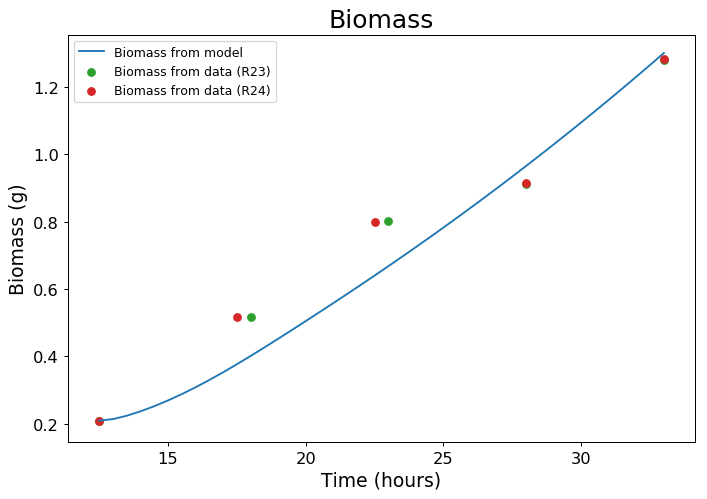

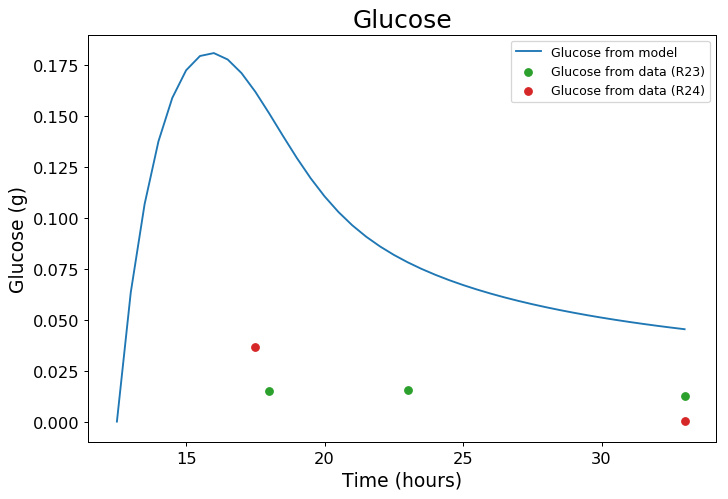

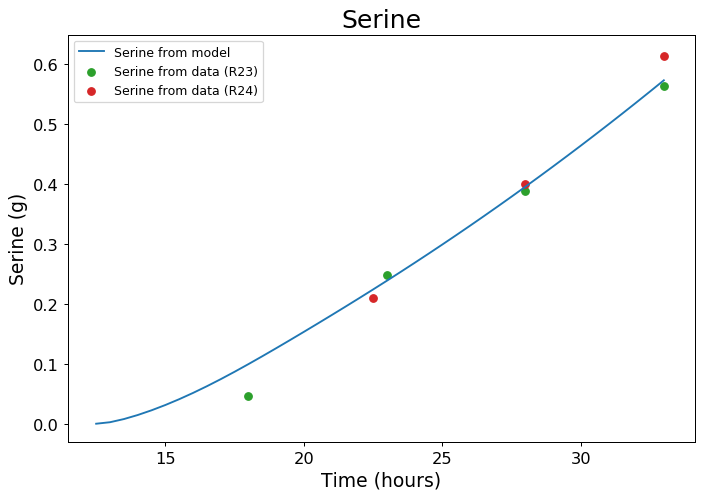

In [8]:
# Plot of the results from the model and the experimental data
plt.figure(num=None, figsize=(9, 6), dpi=90, facecolor='w', edgecolor='k')

plt.plot(results[:, 0], results[:, 2])
plt.scatter(R23_amounts['Time (hours)'][:5], R23_amounts['Biomass (g)'][:5], color = 'C2')
plt.scatter(R24_amounts['Time (hours)'][:5], R24_amounts['Biomass (g)'][:5], color = 'C3')
plt.legend(['Biomass from model', 'Biomass from data (R23)', 'Biomass from data (R24)'], loc='upper left')
plt.xlabel('Time (hours)', fontsize = 15)
plt.ylabel('Biomass (g)', fontsize = 15)
plt.title('Biomass', fontsize = 20)
plt.savefig('figures/modeloutput/fedbatch/estparfedbatch_biomass.png')

plt.show()

plt.figure(num=None, figsize=(9, 6), dpi=90, facecolor='w', edgecolor='k')

plt.plot(results[:, 0], results[:, 1])
plt.scatter(R23_amounts['Time (hours)'][:5], R23_amounts['Glucose (g)'][:5], color = 'C2')
plt.scatter(R24_amounts['Time (hours)'][:5], R24_amounts['Glucose (g)'][:5], color = 'C3')
plt.legend(['Glucose from model', 'Glucose from data (R23)', 'Glucose from data (R24)'], loc='upper right')
plt.xlabel('Time (hours)', fontsize = 15)
plt.ylabel('Glucose (g)', fontsize = 15)
plt.title('Glucose', fontsize = 20)
plt.savefig('figures/modeloutput/fedbatch/estparfedbatch_glucose.png')


plt.show()

plt.figure(num=None, figsize=(9, 6), dpi=90, facecolor='w', edgecolor='k')

plt.plot(results[:, 0], results[:, 3])
plt.scatter(R23_amounts['Time (hours)'][:5], R23_amounts['Serine (g)'][:5], color = 'C2')
plt.scatter(R24_amounts['Time (hours)'][:5], R24_amounts['Serine (g)'][:5], color = 'C3')
plt.legend(['Serine from model', 'Serine from data (R23)', 'Serine from data (R24)'], loc='upper left')
plt.xlabel('Time (hours)', fontsize = 15)
plt.ylabel('Serine (g)', fontsize = 15)
plt.title('Serine', fontsize = 20)
plt.savefig('figures/modeloutput/fedbatch/estparfedbatch_serine.png')


plt.show()

In [209]:
# When it is decreasing it corresponds to the batch phase and also the beginning of the fed batch phase. 
# When we look at the analytical data we can actually see that we have higher acetate concentration here. 
#plt.scatter(results[:,4][:], R23_CO2_selected['Bioreactor 23 - OUR'][:67]/results[:, 2])
#plt.show()

In [210]:
#mu_R24[25:67]
#print(R24_CO2_selected[25:67])
#len(results[:,4][27:])
len(mu_R24[25:67])

42

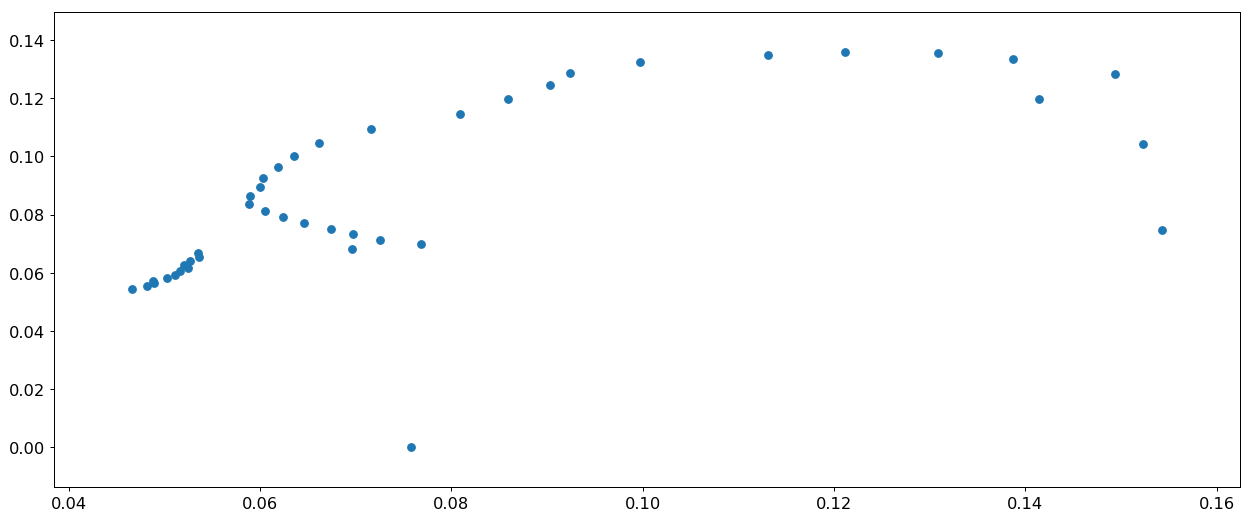

1.0157664644714879 0.015994488710548274 0.8722632831844142 2.039317698644315e-12 0.09626171426103611


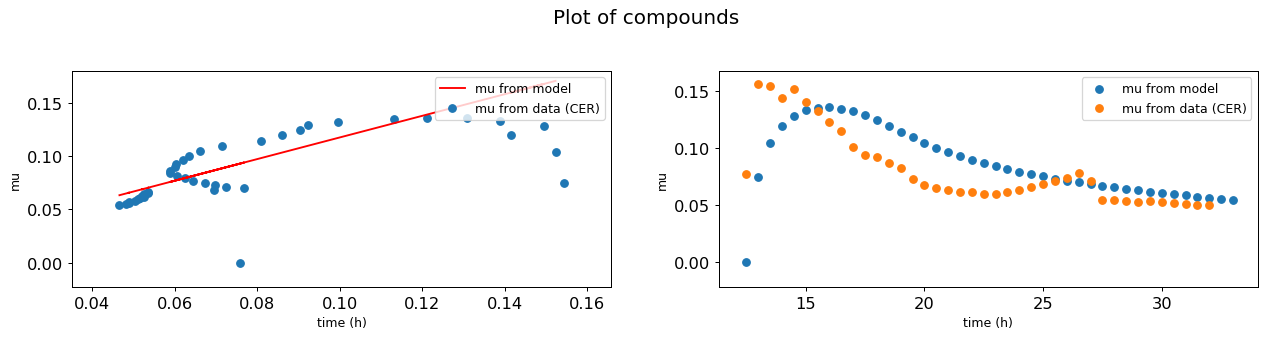

In [213]:
plt.figure(num=None, figsize=(17, 7), dpi=90, facecolor='w', edgecolor='k')
plt.scatter(mu_R24[25:67],results[:,4])
plt.show()


slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(mu_R24[30:67], results[:,4][5:])
print(slope, intercept, r_value, p_value, std_err)

plt.figure(num=None, figsize=(17, 7), dpi=90, facecolor='w', edgecolor='k')
plt.suptitle('Plot of compounds', fontsize=16)

plt.subplot(2, 2, 1)
plt.scatter(mu_R24[25:67], results[:,4])
plt.plot(mu_R24[27:67], intercept + slope*mu_R24[27:67], 'r', label='fitted line')
plt.xlabel('time (h)')
plt.ylabel('mu')
plt.legend(['mu from model', 'mu from data (CER)'], loc='upper right')


plt.subplot(2, 2, 2)
plt.scatter(results[:,0],results[:,4])
plt.scatter(R24_CO2_selected['Time'][25:65], mu_R24[25:65]*slope)
plt.xlabel('time (h)')
plt.ylabel('mu')
plt.legend(['mu from model', 'mu from data (CER)'], loc='upper right')


plt.show()

In [215]:
#plt.plot(mu_R23[:67]*1.0157664644714879, R23_CO2_selected['Bioreactor 23 - OUR'][:67]/results[:, 2])
#plt.show()

In [ ]:
# Plot of the results from the model and the experimental data
plt.figure(num=None, figsize=(9, 6), dpi=90, facecolor='w', edgecolor='k')

plt.plot(results[:, 0], results[:, 2])
plt.scatter(R23_amounts['Time (hours)'][:5], R23_amounts['Biomass (g)'][:5], color = 'C2')
plt.scatter(R24_amounts['Time (hours)'][:5], R24_amounts['Biomass (g)'][:5], color = 'C3')
plt.legend(['Biomass from model', 'Biomass from data (R23)', 'Biomass from data (R24)'], loc='upper left')
plt.xlabel('Time (hours)', fontsize = 15)
plt.ylabel('Biomass (g)', fontsize = 15)
plt.title('Biomass', fontsize = 20)
plt.savefig('figures/modeloutput/fedbatch/estparfedbatch_biomass.png')

plt.show()

plt.figure(num=None, figsize=(9, 6), dpi=90, facecolor='w', edgecolor='k')

plt.plot(results[:, 0], results[:, 1])
plt.scatter(R23_amounts['Time (hours)'][:5], R23_amounts['Glucose (g)'][:5], color = 'C2')
plt.scatter(R24_amounts['Time (hours)'][:5], R24_amounts['Glucose (g)'][:5], color = 'C3')
plt.legend(['Glucose from model', 'Glucose from data (R23)', 'Glucose from data (R24)'], loc='upper right')
plt.xlabel('Time (hours)', fontsize = 15)
plt.ylabel('Glucose (g)', fontsize = 15)
plt.title('Glucose', fontsize = 20)
plt.savefig('figures/modeloutput/fedbatch/estparfedbatch_glucose.png')


plt.show()

plt.figure(num=None, figsize=(9, 6), dpi=90, facecolor='w', edgecolor='k')

plt.plot(results[:, 0], results[:, 3])
plt.scatter(R23_amounts['Time (hours)'][:5], R23_amounts['Serine (g)'][:5], color = 'C2')
plt.scatter(R24_amounts['Time (hours)'][:5], R24_amounts['Serine (g)'][:5], color = 'C3')
plt.legend(['Serine from model', 'Serine from data (R23)', 'Serine from data (R24)'], loc='upper left')
plt.xlabel('Time (hours)', fontsize = 15)
plt.ylabel('Serine (g)', fontsize = 15)
plt.title('Serine', fontsize = 20)
plt.savefig('figures/modeloutput/fedbatch/estparfedbatch_serine.png')


plt.show()

## Integrate mu 

In [225]:
mu_model = '''
model *IDModel()

    ######## Set the compartment to 1, otherwise it will be multiplied by the compounds. 
    compartment comp1;
    comp1 =1;


    ######## Specify the species in the compartment
    glucose in comp1; biomass in comp1; serine in comp1; #acetate in comp1


    ######## Constants
    mu_max = 0.2477 # [1/h]
    Ks = 1.4344 # [g/L]
    Ks_qs = 2.6784 # [g/L]
    Ki = 688309 # [g/L]
    qs_max = 1.4075 # (g/(g*h))
    F0 = 0.3
    mu_set = 0.02
    alpha = 1.5007
    beta = 2.7714

    ######## Initial conditions
    V = 0.1021
    glucose = 0 # 0.149770*V # [g]
    biomass = 0.209504 #5.092*V # [g]
    serine = 0 # [g]
    
    ######## Feed function
    Fin := F0*exp(mu_set*time)/1000 # [L/h]
    
    
    ######## Function for volume in fed-batch
    EqVolume: -> V; Fin # [L/h]
    
    ######## Initial concentrations
    c_glucose := glucose/V # [g/L]
    c_glufeed = 415 # [g/L]
    c_biomass := biomass/V


    ######## Functions
    mu = 0 # [1/h]
    qs := qs_max*c_glucose/(Ks_qs+c_glucose) # [g_substrate/g_biomass h]
    qp := alpha*mu/(mu+beta)
    
    
    ######## Mass Balances 
    eq_biomass: -> biomass; mu*biomass # [g/h]
    eq_glucose: -> glucose; -qs*biomass + Fin*c_glufeed -0.002 # [g/h]  
    eq_serine: -> serine; qp*biomass # [g/h]
    

    end
'''

r = te.loada(mu_model)



#r.exportToSBML('model_and_estimation/model_fedbatch_batchphase.xml')
r.timeCourseSelections = ['time','glucose','biomass','serine','mu', 'Fin', 'V','qs','qp']
results = r.simulate(12.5, 33, 41)
results

       time,   glucose,  biomass, serine, mu,         Fin,        V,       qs, qp
 [[    12.5,         0, 0.209504,      0,  0, 0.000385208,   0.1021,        0,  0],
  [ 13.0125, 0.0648223, 0.209504,      0,  0, 0.000389176, 0.102298, 0.269281,  0],
  [  13.525,  0.110232, 0.209504,      0,  0, 0.000393186, 0.102499, 0.403237,  0],
  [ 14.0375,  0.145205, 0.209504,      0,  0, 0.000397237, 0.102701, 0.486286,  0],
  [   14.55,  0.173626, 0.209504,      0,  0, 0.000401329, 0.102906,  0.54397,  0],
  [ 15.0625,  0.197579, 0.209504,      0,  0, 0.000405464, 0.103113, 0.586995,  0],
  [  15.575,  0.218331, 0.209504,      0,  0, 0.000409642, 0.103322, 0.620724,  0],
  [ 16.0875,  0.236711, 0.209504,      0,  0, 0.000413862, 0.103533, 0.648176,  0],
  [    16.6,  0.253298, 0.209504,      0,  0, 0.000418126, 0.103746,  0.67119,  0],
  [ 17.1125,  0.268508, 0.209504,      0,  0, 0.000422434, 0.103961, 0.690958,  0],
  [  17.625,  0.282653, 0.209504,      0,  0, 0.000426786, 0.104179, 0.708286,

In [226]:
start_time = R23_CO2_selected['Time'][25:67][25]
end_time = R23_CO2_selected['Time'][25:67][26]


r = te.loada(mu_model)
    
    
r.timeCourseSelections = ['time','glucose','biomass','serine','mu']

results = r.simulate(start_time, end_time, 2)

initial_values = results[0:1]
data_frame = pd.DataFrame(initial_values)
data_frame.columns = ['time', 'glucose', 'biomass', 'serine', 'mu']
mu_R24[25:67] = mu_R24[25:67]*1.0157664644714879
data_frame
mu_R24[25:67]

25    0.079426
26    0.161664
27    0.159640
28    0.148253
29    0.156606
30    0.145421
31    0.137143
32    0.126944
33    0.118566
34    0.104493
35    0.096809
36    0.094632
37    0.090081
38    0.084778
39    0.074996
40    0.069287
41    0.066572
42    0.064874
43    0.063221
44    0.062881
45    0.061728
46    0.061622
47    0.063373
48    0.065416
49    0.067659
50    0.070653
51    0.073017
52    0.075990
53    0.080516
54    0.072924
55    0.056112
56    0.056220
57    0.055189
58    0.054514
59    0.054985
60    0.054074
61    0.053568
62    0.052721
63    0.051198
64    0.051302
65    0.050490
66    0.048854
Name: Bioreactor 24 - CER, dtype: float64

In [227]:
for i in range(25, 66):
    
    r.mu = mu_R24[25:][i+1]
    glucose = data_frame['glucose'].iloc[-1]
    serine = data_frame['serine'].iloc[-1]
    biomass = data_frame['biomass'].iloc[-1]
    
    start_time = R23_CO2_selected['Time'][25:][i]
    end_time = R23_CO2_selected['Time'][25:][i + 1]
    results = r.simulate(start_time, end_time, 2)
    
    simulated_row = results[-1:]
    new_dataframe = pd.DataFrame(simulated_row)
    new_dataframe.columns = ['time', 'glucose', 'biomass', 'serine', 'mu']
    data_frame = data_frame.append(new_dataframe, ignore_index=True)
    
data_frame

,time,glucose,biomass,serine,mu
0,12.5,0.000000,0.209504,0.000000,0.000000
1,13.0,0.106185,0.227142,0.009024,0.161664
2,13.5,0.135245,0.246016,0.018688,0.159640
3,14.0,0.154073,0.264945,0.028417,0.148253
4,14.5,0.164637,0.286525,0.039478,0.156606
5,15.0,0.168450,0.308135,0.050596,0.145421
6,15.5,0.167100,0.330005,0.061881,0.137143
7,16.0,0.162054,0.351631,0.073078,0.126944
8,16.5,0.154655,0.373107,0.084230,0.118566
9,17.0,0.146168,0.393119,0.094673,0.104493


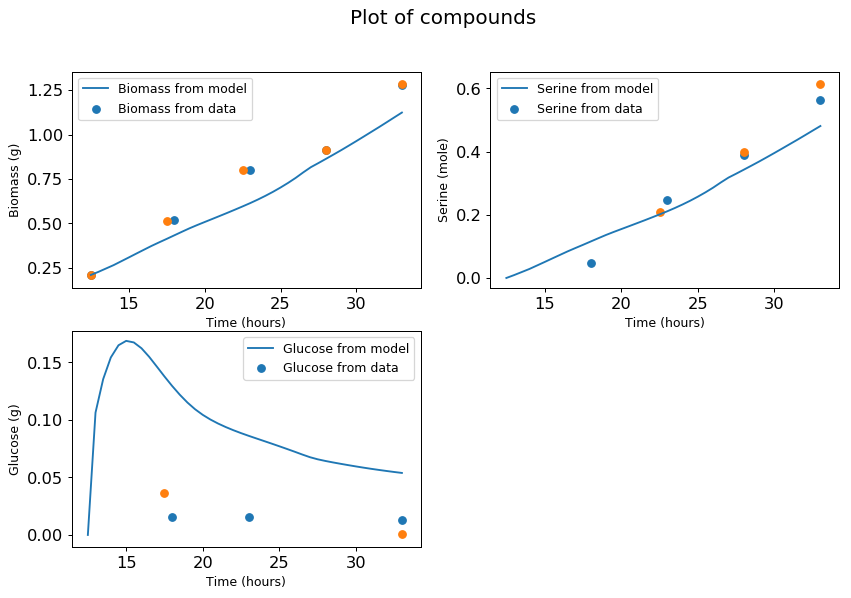

In [228]:
# Plot of the results from the model and the experimental data
plt.figure(num=None, figsize=(11, 7), dpi=90, facecolor='w', edgecolor='k')
plt.suptitle('Plot of compounds', fontsize=16)

plt.subplot(2, 2, 1)
plt.plot(data_frame['time'], data_frame['biomass'])
plt.scatter(R23_amounts['Time (hours)'][:5], R23_amounts['Biomass (g)'][:5])
plt.scatter(R24_amounts['Time (hours)'][:5], R24_amounts['Biomass (g)'][:5])
plt.legend(['Biomass from model', 'Biomass from data'], loc='upper left')
plt.xlabel('Time (hours)')
plt.ylabel('Biomass (g)')

plt.subplot(2, 2, 2)
plt.plot(data_frame['time'], data_frame['serine'])
plt.scatter(R23_amounts['Time (hours)'][:5], R23_amounts['Serine (g)'][:5])
plt.scatter(R24_amounts['Time (hours)'][:5], R24_amounts['Serine (g)'][:5])
plt.legend(['Serine from model', 'Serine from data'], loc='upper left')
plt.xlabel('Time (hours)')
plt.ylabel('Serine (mole)')

plt.subplot(2, 2, 3)
plt.plot(data_frame['time'], data_frame['glucose'])
plt.scatter(R23_amounts['Time (hours)'][:5], R23_amounts['Glucose (g)'][:5])
plt.scatter(R24_amounts['Time (hours)'][:5], R24_amounts['Glucose (g)'][:5])
plt.legend(['Glucose from model', 'Glucose from data'], loc='upper right')
plt.xlabel('Time (hours)')
plt.ylabel('Glucose (g)')

#plt.subplot(2, 2, 4)
#plt.scatter(mu_data_R24['Time (hours)'][25:], mu_data_R24['mu (1/h)'][25:])
#plt.legend(['Growth rate from CER'], loc='upper right')
#plt.xlabel('Time (hours)')
#plt.ylabel('mu (1/h)')



plt.show()

## With batch phase (problem: there is another assignment rule for mu from batch phase)

In [240]:
mu_model = '''
model *IDModel()

    ######## Set the compartment to 1, otherwise it will be multiplied by the compounds. 
    compartment comp1;
    comp1 =1;


    ######## Specify the species in the compartment
    glucose in comp1; biomass in comp1; serine in comp1; #acetate in comp1


    ######## Constants
    mu_max = 0.2477 # [1/h]
    Ks = 1.4344 # [g/L]
    Ks_qs = 2.6784 # [g/L]
    Ki = 688309 # [g/L]
    qs_max = 1.4075 # (g/(g*h))
    F0 = 0.3
    mu_set = 0.02
    alpha = 1.5007
    beta = 2.7714
    switch = 0
    IPTG = 0

    ######## Initial conditions
    V = 0.1021
    glucose = 10*V #0 # 0.149770*V # [g]
    biomass_init = 0.15 # [g/L]
    biomass = biomass_init*V  # [g]
    serine = 0 # [g]
    
    ######## Feed function
    Fin := switch*F0*exp(mu_set*time)/1000 # [L/h]
    
    ######## If fed batch
    at (time > 12.5): switch = 1, IPTG = 1
    
    ######## Function for volume in fed-batch
    EqVolume: -> V; Fin # [L/h]
    
    ######## Initial concentrations
    c_glucose := glucose/V # [g/L]
    c_glufeed = 415 # [g/L]
    c_biomass := biomass/V


    ######## Functions
    mu = 0
    qs := qs_max*c_glucose/(Ks_qs+c_glucose) # [g_substrate/g_biomass h]
    qp := alpha*mu/(mu+beta)*IPTG
    
    
    ######## Mass Balances 
    eq_biomass: -> biomass; mu*biomass # [g/h]
    eq_glucose: -> glucose; -qs*biomass + Fin*c_glufeed # [g/h]  
    eq_serine: -> serine; qp*biomass*IPTG # [g/h]
    
    yield := serine/glucose
    qpbio := qp*biomass
    

    end
'''

r = te.loada(mu_model)


#r.exportToSBML('model_and_estimation/model_fedbatch_batchphase.xml')
r.timeCourseSelections = ['time','glucose','biomass','serine','mu', 'Fin', 'V','qs','qp']
results = r.simulate(0, 33, 67)

In [ ]:
start_time = R23_CO2_selected['Time'][25:67][25]
end_time = R23_CO2_selected['Time'][25:67][26]


r = te.loada(mu_model)
    
    
r.timeCourseSelections = ['time','glucose','biomass','serine','mu']

results = r.simulate(start_time, end_time, 2)

initial_values = results[0:1]
data_frame = pd.DataFrame(initial_values)
data_frame.columns = ['time', 'glucose', 'biomass', 'serine', 'mu']
mu_R24[25:67] = mu_R24[25:67]*1.0157664644714879
data_frame
mu_R24[25:67]